# TODO list fra mandag d. 24/4 kl.15:36

Jeg skal fikse/finde ud af hvordna de der k-vektor fungere med class og Kn.

Mit indtryk er at jeg bliver nød til at kalde class rigtig mange mange gange og der lyder lidt uhyggeligt.

Så få fat i Thomas eller Emil.


$\ddot{D}+\mathcal{H}\dot{D}-\frac{3}{2}\frac{H_0^2\Omega_m}{a}D=0$

$(\mathcal{H}\dot{D}D+\ddot{D}D+2\dot{D}^2)b_-+(4D\dot{D}+\mathcal{H}D^2)\dot{b}_-+2D^2\ddot{b}_-=\frac{3}{2}H_0^2 \Omega_m\frac{D^2}{a}$

For now let us assume equilateral configurations, thsi means $k_1\sim k_2 \sim k_3 \rightarrow \hat{k}_1 \cdot\hat{k}_2 = |k|^2 \cos(60^{\circ})=\frac{1}{2}|k|^2 $ 



In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special
from time import time

cs(1)=0.00019477974533539888
{1e-07: -1.845403057663627e-07, 7.742636826811278e-07: -1.1062905907341485e-05, 5.994842503189409e-06: -0.0006632033525981784, 4.641588833612773e-05: -0.039756069584889836, 0.00035938136638046257: -2.376854447829176, 0.002782559402207126: -132.94499747406635, 0.021544346900318822: -3853.534871502382, 0.16681005372000557: -24352.68236681233, 1.2915496650148826: -60277.31614902127, 10.0: -100539.96956967235}
Test run


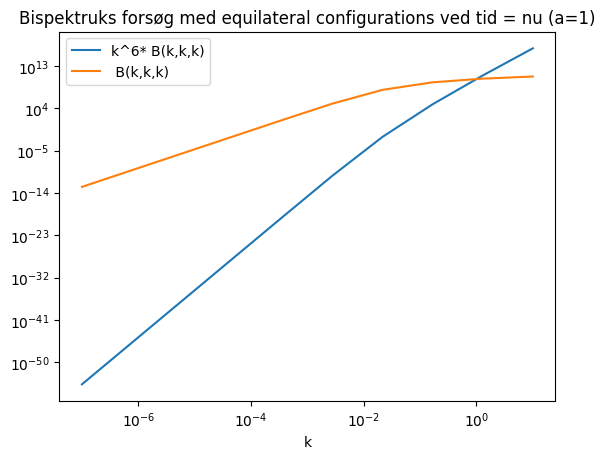

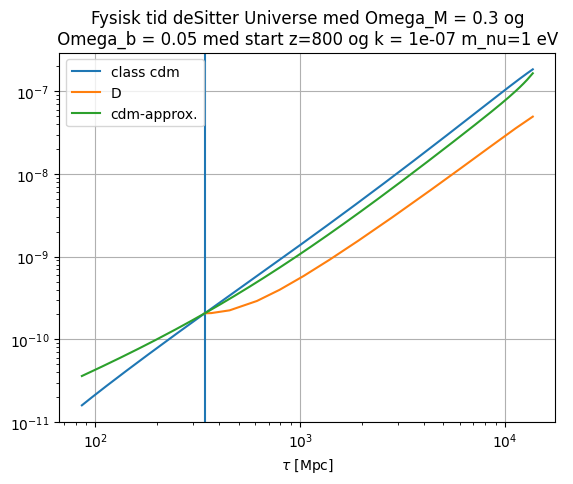

In [47]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    a_class = pts[k_ind]["a"]

    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
    theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
    a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)
    
    a0 = 1/(1+z)
    a_span = [a0,1]
    T0 = float(interp_tau_from_a(a0))
    delta0 = delta_interp(T0)
    t0 = tau_class[-1]
    tspan = [T0,t0]
    t = np.logspace(np.log10(T0),np.log10(t0),100)

    def Dfunc(tau,y):
        a = a_interp(tau)
        D = y[0]
        dD = y[1]
        d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
        
        b = y[2]
        db = y[3]
        d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
        return [dD,d2D,db,d2b]

    start0 = [delta_interp(T0),theta_interp(T0),0,0]
    sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
    D = scipy.interpolate.interp1d(sol.t,-sol.y[0])
    b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
    t = sol.t
    
    #plt.loglog(t,D(t),label="D")
    #plt.loglog(t,-b(t),label="b_")
    
    norm = lambda x: np.linalg.norm(x)
    
    def KN(k1,k2,k ,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 * np.vdot(k1,k2) * (1/norm(k1)**2 + 1/norm(k2)**2) + an * 1/(norm(k1)**2 * norm(k2)**2) * np.vdot(k1,k2)**2
    
    def KN2(k ,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 * 1**2 *0.5 * (k/k+k/k) + an * (1**2 * 1/2)**2
    
    delta_list = {kind:pts[i]["delta_cdm"][-1] for i,kind in enumerate(kvec)}
    print(delta_list)
    #print(delta_list[1])
    
    def Bispektrum(k):
        return 2 * (delta_list[k]*delta_list[k] * KN2(k)
                    +delta_list[k]*delta_list[k] * KN2(k) 
                    +delta_list[k]*delta_list[k] * KN2(k) )
    
    
    #print(Bispektrum(1))
    B = [Bispektrum(i) for i in kvec]
    plt.figure(np.random.randint(0,100))
    plt.title("Bispektruks forsøg med equilateral configurations ved tid = nu (a=1)")
    plt.loglog(kvec,B*np.array(kvec)**6, label="k^6* B(k,k,k)")
    plt.loglog(kvec,B, label=" B(k,k,k)")
    plt.xlabel("k")
    plt.legend()
    plt.figure(np.random.randint(0,100))
    plt.axvline(T0)
    plt.plot(tau_class,-delta_class,label="class cdm")
    plt.xlabel("$\\tau$ [Mpc]")
    plt.loglog(t,D(t),label="D")
    plt.loglog(tau_class,-delta0/a0*a_class,label="cdm-approx.")
    plt.legend()
    plt.title("Fysisk tid deSitter Universe med Omega_M = %s og\n Omega_b = %s med start z=%s og k = %s m_nu=%s eV " %(Omega_M,Omega_b,z,k,mv_test))
    print("Test run")
    #print(f"{KN(k1,k2,k3)=}")
    plt.grid()
    
kvec1=list(np.logspace(-7,1,10))
TEST(kvec = kvec1)#[1e-3,1e-2,1e-1,1e0,1e1,1e2])

In [32]:
"""# i conformal time
k_ind = 0
kvec = [1]
k = kvec[k_ind]

Omega_M = 0.3
Omega_b = 7e-5
Omega_lambda = 1 - Omega_M - Omega_b
# CLASS stuff
H0=67
Tv_k = 1.947
# in MeV
kb = 8.617e-11 
# MeV/K
T0 = Tv_k * kb
mv_test = 1

cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]') # 'Omega_b':Omega_b,
         ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            , "YHe":0.25
            }

c = 3*1e5 
# speed of lign in km/s

H0 /= c 
# i 1/Mpc

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
tau_class = pts[k_ind]["tau [Mpc]"]
tau = bg['conf. time [Mpc]']



z = 300

a0 = 1/(1+z)

def H(tau):
    a = 1/4 * H0 **2 * tau**2
    return H0 * np.sqrt(Omega_M / a + Omega_lambda * a**2)

def D_func(tau,y):
    D = y[0]
    dD= y[1]
    b = y[2]
    db = y[3]
    a = y[4]
    d2D = - H(tau) * db + 3/2 * H0**2 * Omega_M *D/a
    d2b = 1/(2*D**2) * (3/2 * H0**2 * Omega_M * D**2/a - (H(tau)* dD*D+ d2D*D+2*dD**2)*b - (4*D*dD+ H(tau)*D**2)*db)
    da = H0 * np.sqrt(a*Omega_M+ a**4 * Omega_lambda)
    return [dD,d2D,db,d2b,da]

dadt = 0

y0 = np.array([1,1,1,1,a0])
# tstart
T0 = np.sqrt(4 * a0 / H0**2 )

# tslut
#print(bg)
t0 = tau[-1]

tspan = [T0,t0]


sol = scipy.integrate.solve_ivp(D_func,tspan,y0)

plt.loglog(sol.t,sol.y[-1])

"""

'# i conformal time\nk_ind = 0\nkvec = [1]\nk = kvec[k_ind]\n\nOmega_M = 0.3\nOmega_b = 7e-5\nOmega_lambda = 1 - Omega_M - Omega_b\n# CLASS stuff\nH0=67\nTv_k = 1.947\n# in MeV\nkb = 8.617e-11 \n# MeV/K\nT0 = Tv_k * kb\nmv_test = 1\n\ncosmo_dict ={\'H0\':H0, \'Omega_cdm\':Omega_M, \'k_output_values\':str(kvec).strip(\'[]\') # \'Omega_b\':Omega_b,\n         ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s\' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre\n           ,\'output\':\'tCl, lCl, dTk, vTk, pCl\', \'lensing\':\'yes\',\n            "ncdm_fluid_approximation":3\n            , "YHe":0.25\n            }\n\nc = 3*1e5 \n# speed of lign in km/s\n\nH0 /= c \n# i 1/Mpc\n\ncosmo = Class()\ncosmo.set(cosmo_dict)\ncosmo.compute()\nbg = cosmo.get_background()\npts = cosmo.get_perturbations()[\'scalar\']\ntau_class = pts[k_ind]["tau [Mpc]"]\ntau = bg[\'conf. time [Mpc]\']\n\n\n\nz = 300\n\na0 = 1/(1+z)\n\ndef H(tau):\n    a = 1/4 * H0 **2 * tau**2\n    return H0 * np.sqrt(